In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize

def geradataset(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]]):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.2)
    y = np.array(y%2, dtype=int)
    return X, y

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)


In [60]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.erro(y, ypred))

In [61]:
class DescidaGradiente():
    def __init__(self, custo=Adaline(), maxiter=1000, alpha=0.005):
        self.custo = custo
        self.maxiter = maxiter
        self.alpha = alpha
    
    def getW(self, X, y, activation=lambda a: a):
        w = np.random.uniform(-1, -1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.maxiter):
            ypred = activation(np.matmul(X, w))
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            w = w + self.alpha * self.custo.gradiente(y, ypred, X)
        return w

class PseudoInversa():
    def __init__(self):
        pass
    def getW(self, X, y):
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

In [62]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

def tanh(a):
    return expit(a) * 2 - 1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    def __init__(self, algoritmo=PseudoInversa()):
        self.wih = None
        self.w = None
        self.threshold = 0
        self.activation = tanh
        self.algoritmo = algoritmo
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb
    
    def fit(self, X, y):
        self.wih = np.random.uniform(-1, 1, size=(X.shape[1],X.shape[1] * 3))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        if len(self.labels) == 2 :
            y = y[:,0:1]
        # treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getW(X, y, self.activation)
        else:
            self.w = self.algoritmo.getW(X, y)

    def predict(self, X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        Xb = ExtremeLearningMachine.includebias(Xho)
        a = np.matmul(Xb, self.w)
        if self.w.shape[1] > 1:
            idx = np.argmax(a, axis=1) 
        else:
            idx = np.array(self.activation(a) > self.threshold, dtype=int)[:,0]
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

In [78]:
elm = ExtremeLearningMachine()
X, y = geradataset(100)
elm.fit(X, y)
ypred = elm.predict(X)
print(sum(y == ypred)/len(y))


0.97


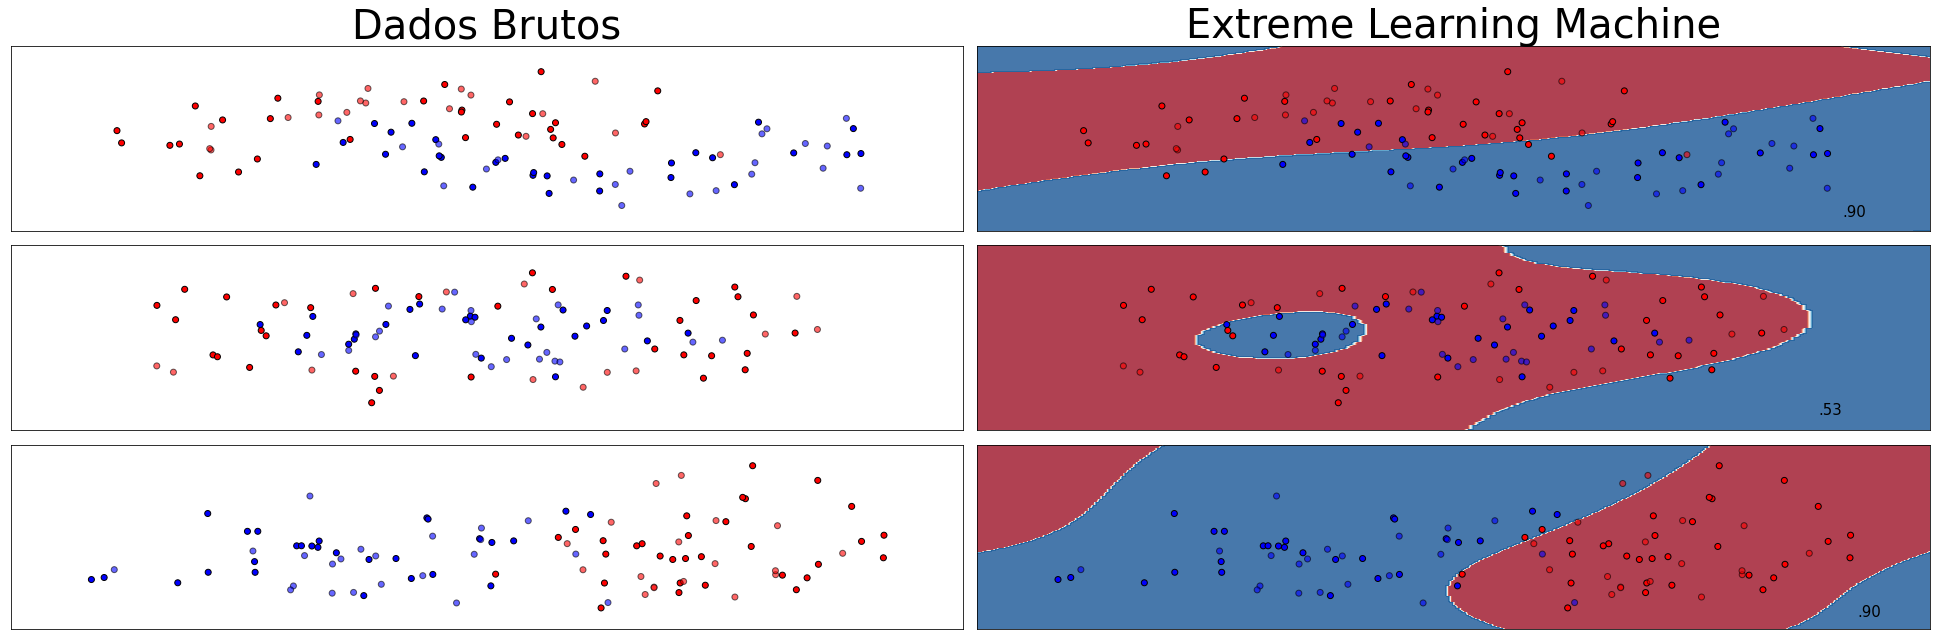

In [81]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

h = .02  # step size in the mesh

names = ["Extreme Learning Machine"]

classifiers = [elm]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]


figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    #X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Dados Brutos", size=40)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name, size=40)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()